In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import re
import datetime
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import warnings

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("complaints.csv")

In [4]:
df.head(10)

,Unnamed: 0,product_5,narrative,Product,Date received,Sub-product,Issue,Sub-issue,Company,State,Timely response?
0,234,Credit Reporting,Dear Possible Financial Inc you guyss aree rep...,Credit reporting or other personal consumer re...,2024-07-27,Credit reporting,Incorrect information on your report,Account information incorrect,Possible Financial Inc,MI,Yes
1,240,Debt Collection,"XXXX XXXX XXXX ( debt collector ), sent my boy...",Debt collection,2024-07-27,I do not know,Threatened to contact someone or share informa...,Talked to a third-party about your debt,BlueChip Financial,TX,Yes
2,257,Credit Reporting,I been receiving alerts my information was fou...,Credit reporting or other personal consumer re...,2024-07-23,Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,FC HoldCo LLC,SC,Yes
3,271,Credit Reporting,Subject : Dispute of Inaccurate Information on...,Credit reporting or other personal consumer re...,2024-07-27,Credit reporting,Improper use of your report,Reporting company used your report improperly,CORELOGIC INC,GA,Yes
4,276,Loans,They allowed me to use the account for about a...,"Payday loan, title loan, personal loan, or adv...",2024-07-26,Payday loan,Received a loan you didn't apply for,NaN,MoneyLion Inc.,PA,Yes
5,279,Credit Reporting,Do you believe your company owns the promissor...,Credit reporting or other personal consumer re...,2024-07-26,Credit reporting,Improper use of your report,Reporting company used your report improperly,CORELOGIC INC,OH,Yes
6,302,Bank Accounts and Services,I used Wells Fargo Bank to make Payments for M...,"Money transfer, virtual currency, or money ser...",2024-07-30,"Money order, traveler's check or cashier's check",Lost or stolen money order,NaN,WELLS FARGO & COMPANY,NY,Yes
7,324,Loans,I had an installment loan under my name that w...,"Payday loan, title loan, personal loan, or adv...",2024-07-25,Installment loan,Charged fees or interest you didn't expect,NaN,REGIONS FINANCIAL CORPORATION,NJ,Yes
8,328,Debt Collection,Credit acceptance sent me court papers stating...,Debt collection,2024-07-24,Auto debt,Took or threatened to take negative or legal a...,Collected or attempted to collect exempt funds,CREDIT ACCEPTANCE CORPORATION,NY,Yes
9,338,Loans,XXXX Morgage company sent a payment to XXXX XX...,Mortgage,2024-07-24,Conventional home mortgage,Trouble during payment process,"Escrow, taxes, or insurance","SELECT PORTFOLIO SERVICING, INC.",OH,Yes


In [5]:
# 1. Verificar valores ausentes
def missing_values(df):
    missing = df.isnull().sum()
    print("Valores ausentes por coluna:")
    print(missing[missing > 0])

# 2. Estatísticas básicas
def basic_statistics(df):
    print("\nInformação do DataFrame:")
    print(df.info())
    print("\nDescrição das colunas numéricas:")
    print(df.describe())
    print("\nDistribuição de categorias:")
    print(df['Product'].value_counts())

# 3. Contagem de valores únicos em colunas categóricas
def categorical_analysis(df, column):
    plt.figure(figsize=(10, 5))
    sns.countplot(y=df[column], order=df[column].value_counts().index, palette='viridis')
    plt.title(f'Distribuição de {column}')
    plt.xlabel('Contagem')
    plt.ylabel(column)
    plt.show()

# 4. Análise temporal das reclamações
def time_analysis(df, date_column):
    df[date_column] = pd.to_datetime(df[date_column])
    df['YearMonth'] = df[date_column].dt.to_period('M')
    plt.figure(figsize=(12, 6))
    df['YearMonth'].value_counts().sort_index().plot(kind='line', marker='o', color='b')
    plt.title(f'Número de reclamações ao longo do tempo ({date_column})')
    plt.xlabel('Ano-Mês')
    plt.ylabel('Número de reclamações')
    plt.xticks(rotation=45)
    plt.show()

# 5. Distribuição do tamanho dos textos
def text_length_distribution(df, column):
    df['text_length'] = df[column].dropna().apply(len)
    plt.figure(figsize=(10, 5))
    sns.histplot(df['text_length'], bins=30, kde=True, color='purple')
    plt.title(f'Distribuição do tamanho dos textos em {column}')
    plt.xlabel('Número de caracteres')
    plt.ylabel('Frequência')
    plt.show()

# 6. Gerar WordCloud
def generate_wordcloud(df, column):
    text = ' '.join(df[column].dropna()).lower()
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=200).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud das Reclamações')
    plt.show()

In [6]:
missing_values(df)

Valores ausentes por coluna:
Sub-product     52206
Sub-issue      230559
State            7344
dtype: int64


In [7]:
basic_statistics(df)


Informação do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023066 entries, 0 to 2023065
Data columns (total 11 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   Unnamed: 0        int64 
 1   product_5         object
 2   narrative         object
 3   Product           object
 4   Date received     object
 5   Sub-product       object
 6   Issue             object
 7   Sub-issue         object
 8   Company           object
 9   State             object
 10  Timely response?  object
dtypes: int64(1), object(10)
memory usage: 169.8+ MB
None

Descrição das colunas numéricas:
         Unnamed: 0
count  2.023066e+06
mean   2.942257e+06
std    1.548125e+06
min    2.340000e+02
25%    1.631738e+06
50%    2.878855e+06
75%    4.287420e+06
max    5.842318e+06

Distribuição de categorias:
Product
Credit reporting, credit repair services, or other personal consumer reports    807291
Credit reporting or other personal consumer reports                        

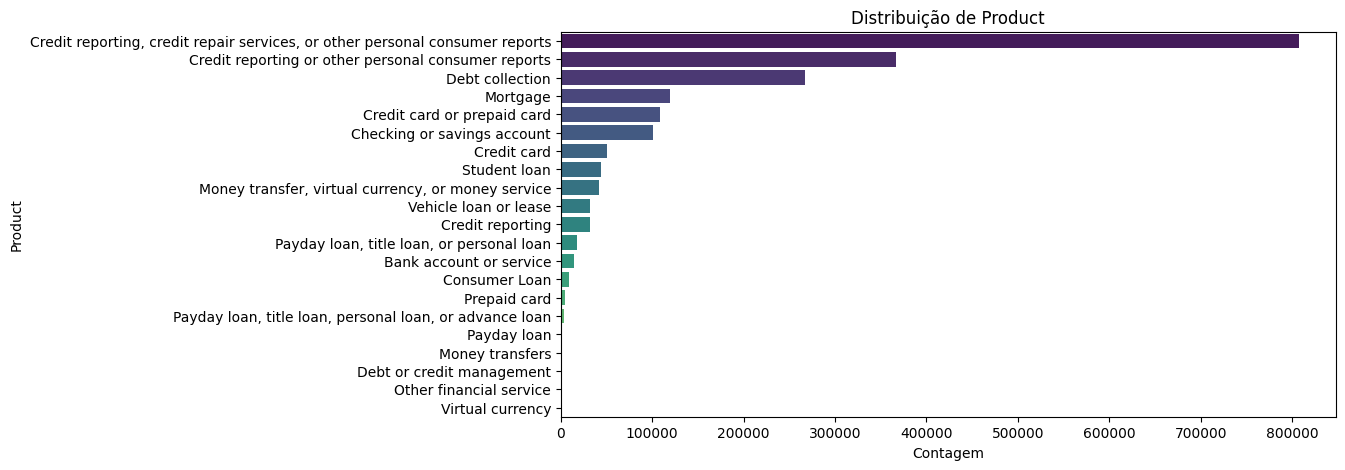

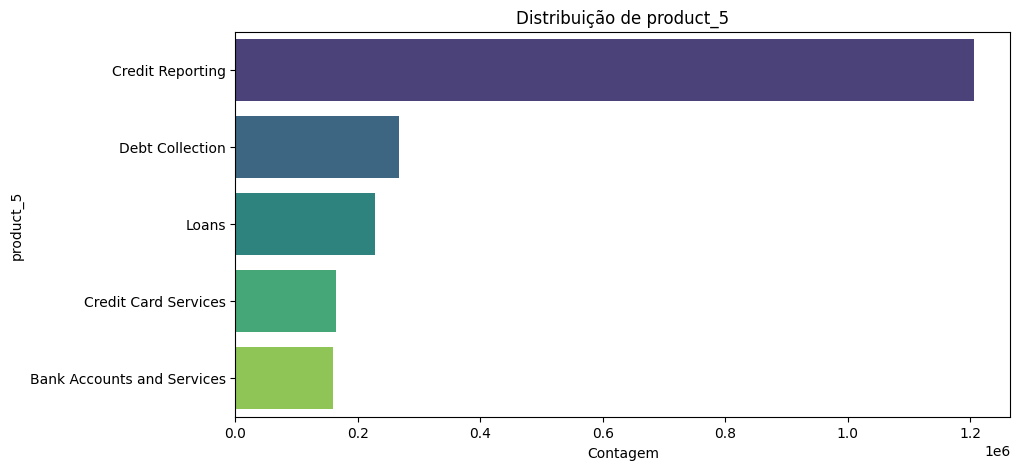

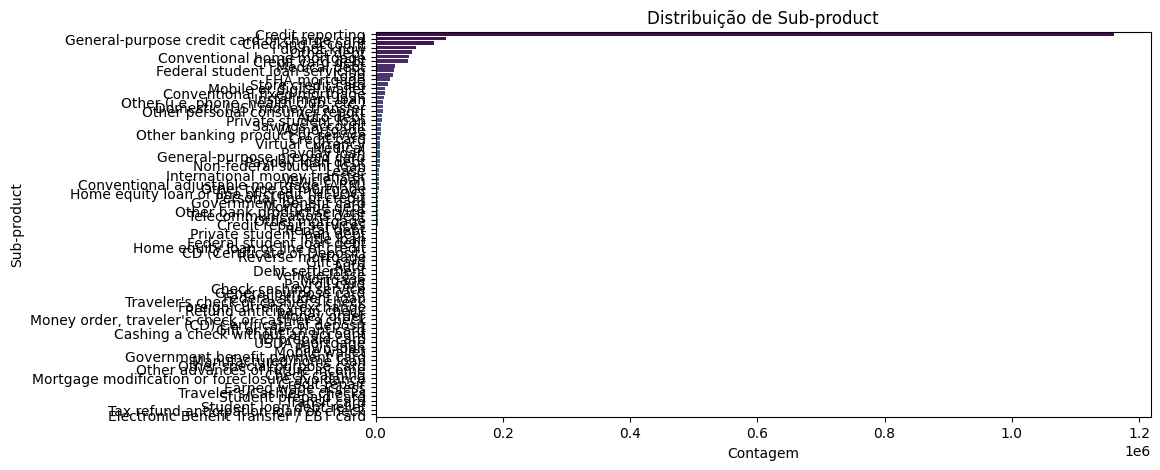

In [8]:
categorical_analysis(df, 'Product')
categorical_analysis(df, 'product_5')
categorical_analysis(df, 'Sub-product')

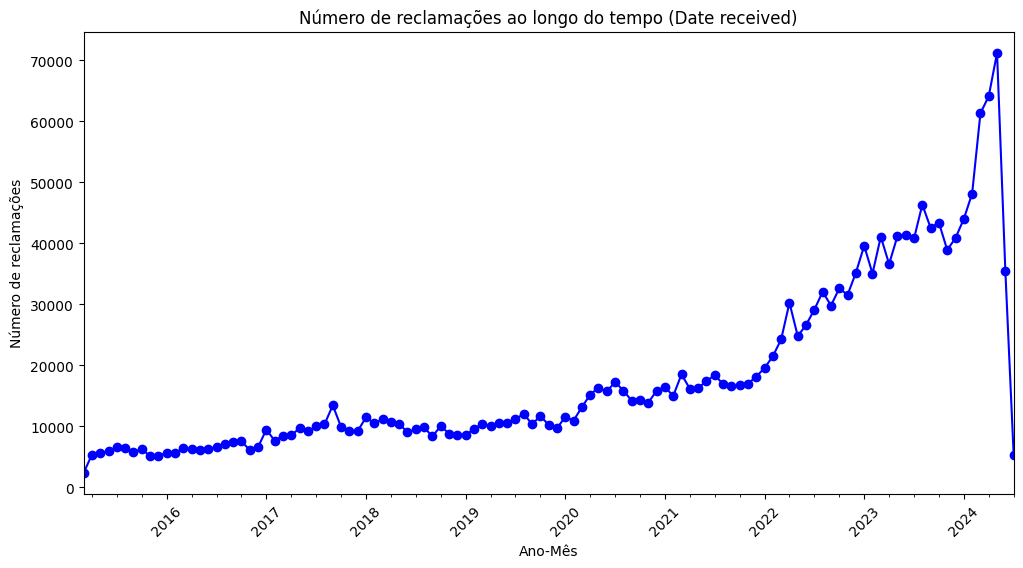

In [9]:
time_analysis(df, 'Date received')

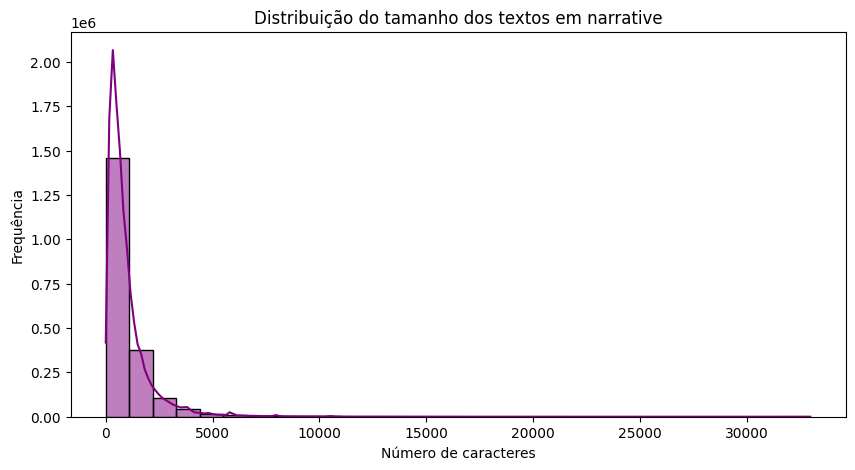

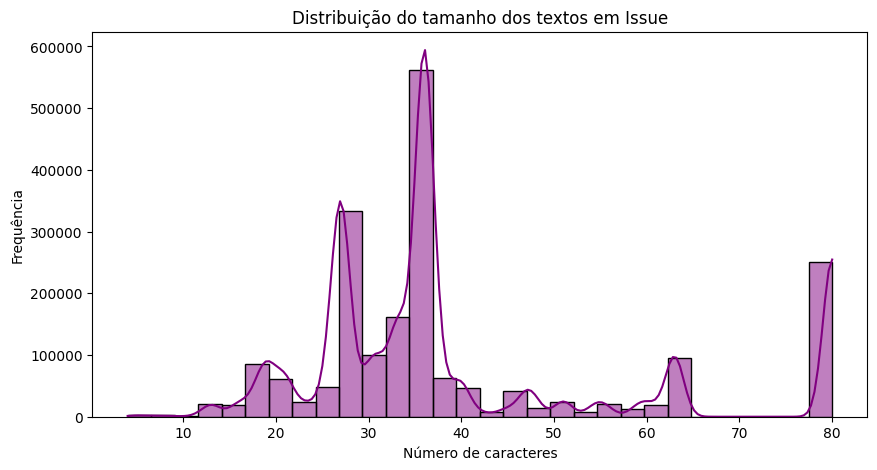

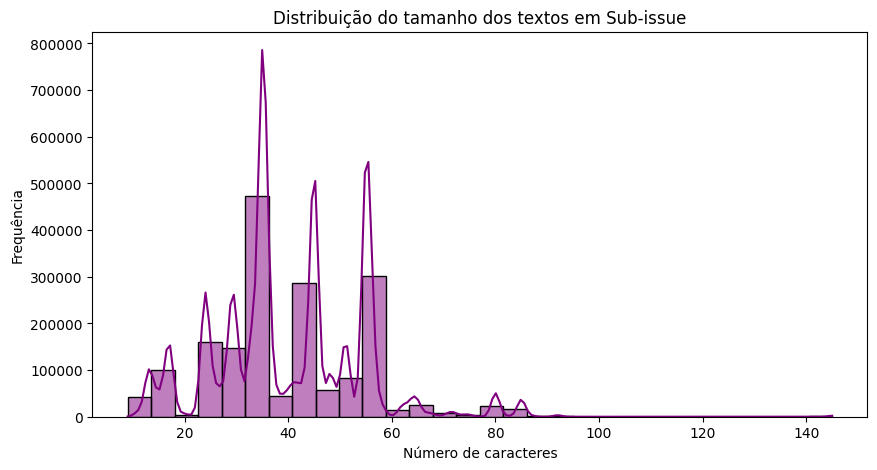

In [10]:
text_length_distribution(df, 'narrative')
text_length_distribution(df, 'Issue')
text_length_distribution(df, 'Sub-issue')

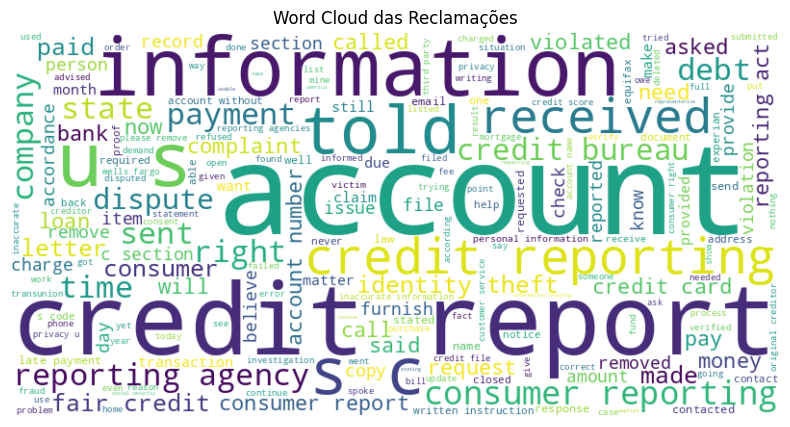

In [ ]:
def clean_text(text):
    return re.sub(r'\b(x+\s*)+\b', '', text, flags=re.IGNORECASE).strip()

# Sample 6% of the data to reduce memory usage
sampled_df = df.sample(frac=0.07, random_state=1)

sampled_df['narrative'] = sampled_df['narrative'].apply(clean_text)

generate_wordcloud(sampled_df, 'narrative')